# Overview of Chi-Square Test
---
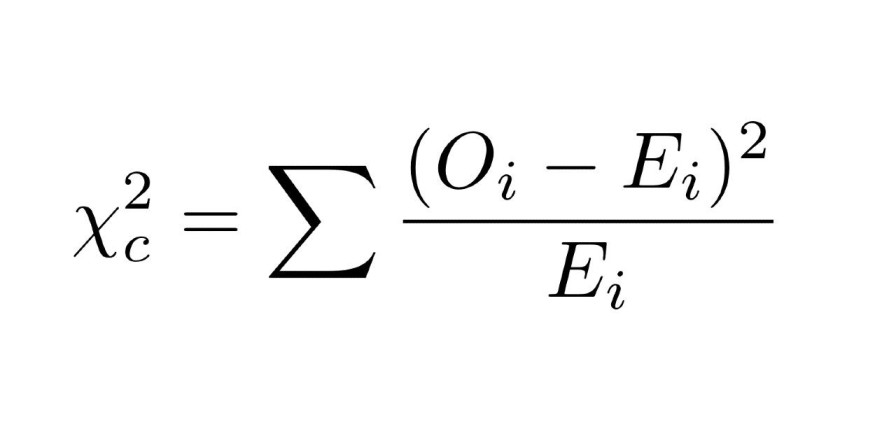

This notebook provides an in-depth analysis of chi-square tests on a medical cost dataset, specifically exploring the relationships between various categorical variables.


In [2]:
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# importing dataset
df = pd.read_csv('insurance.csv')
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,bmi_category
0,0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,3,33,male,22.705,0,no,northwest,21984.47061,normal
4,4,32,male,28.880,0,no,northwest,3866.85520,overweight


In [50]:
# defining a function to generate a chi-square plot
def generate_chi2_plot(critical_val,chi2_stats,_df,size,cl):
    chi2_rvs = stats.chi2.rvs(df=_df, size=size)

    sns.histplot(chi2_rvs, label=f"df={_df}",
                 fill=True,kde=True,color=cl)
    plt.axvline(x=critical_val, color='red', 
                linestyle='--', linewidth=2, 
                label='Critical Value')
    plt.axvline(x=chi2_stats, color='black', 
                linestyle='--', linewidth=2, 
                label='Chi2 Statistic')

    plt.xlabel('Chi-Square Value'.capitalize())
    plt.ylabel('Density'.capitalize())
    plt.title(f'Chi-Square Distribution (df={_df})')

    plt.legend()
    plt.tight_layout()  # Ensure labels fit within the figure area
    plt.show()


# Goodness of Fit-Test
---

- Formula : sum[(obs-exp)**2 / exp] 
- It uses chi-square distribution, where the degree of freedom (df) will be : 1-(total no. of categories)
- Assumption: The frequency of all categories should be greater than 5.
- A greater value of Chi-square statistic represents large difference b/w obs. & expected.


### **if chi2_statistic > critical_value or p_value < 0.05: Reject the Null Hypothesis**




### Formulating Hypothesis: **Is gender a significant factor in the distribution of smokers among individuals seeking medical insurance?**
---
**Null Hypothesis (H0)**: The proportion of male smokers seeking medical insurance is equal to the proportion of female smokers seeking medical insurance.

**Alternative Hypothesis (H1)**: The proportion of male smokers seeking medical insurance is different from the proportion of female smokers seeking medical insurance.

In [55]:
# filtering the data for genders which are smokers
smoker_df = df.query("smoker == 'yes'")['sex'].value_counts().to_frame().reset_index()
equal_prop = smoker_df['count'].sum() // 2

smoker_df.rename(columns={"count":"observed"},inplace=True)
smoker_df['expected'] = equal_prop

# observed & expected frequency
smoker_df

,sex,observed,expected
0,male,159,137
1,female,115,137


In [61]:
# calculating chi2 statistic
chi2_stats = ((smoker_df['observed'] - smoker_df['expected'])**2 / smoker_df['expected']).sum()

# degree of freedom
_df = 1 # only either male or female smoker info is the minimum requirement for the hypothesis

print(f"chi2 statistic: {chi2_stats}")
print(f"degree of freedom: {_df}")

chi2 statistic: 7.065693430656935
degree of freedom: 1


In [62]:
critical_val = stats.chi2.ppf(0.95,df=_df)
print(f"critical value : {critical_val}")

p_value = 1 - stats.chi2.cdf(chi2_stats,_df)
print(f"{p_value=}")

critical value : 3.841458820694124
p_value=0.007857389588994734


In [63]:
chi2_stats > critical_val

True

In [64]:
p_value < 0.05

True

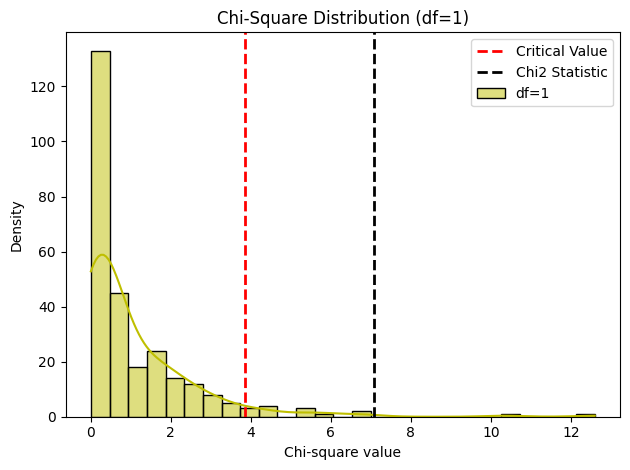

In [65]:
# let's have a look at the chi square test plot
generate_chi2_plot(critical_val=critical_val,
                   chi2_stats=chi2_stats,
                   _df=_df,cl='y',
                   size=equal_prop*2)

>**The chi-square statistic exceed the critical value in the chi2 distribution of df=1, in other words the p-value is less than 0.05. Hence we *reject* the null hypothesis and conclude that there not enough evidence to say that the male and female smokers exist in equal proportion of medical insurance.**


### Formulating Hypothesis: **Do patients from various regions have an equal likelihood of seeking medical insurance?**
---
**Null Hypothesis (H0)**: The patients from all regions have an equal likelihood of seeking medical insurance.

**Alternative Hypothesis (H1)**: The patients from all regions have an unequal likelihood of seeking medical insurance.

In [66]:
region_df = df.region.value_counts().to_frame().reset_index()
equal_prop = region_df['count'].sum() // 4

region_df.rename(columns={"count":"observed"},inplace=True)
region_df['expected'] = equal_prop

# observed & expected frequency
region_df

,region,observed,expected
0,southeast,364,334
1,southwest,325,334
2,northwest,325,334
3,northeast,324,334


In [67]:
# calculating chi2 statistic
chi2_stats = ((region_df['observed'] - region_df['expected'])**2 / region_df['expected']).sum()
# degree of freedom
_df = 3

print(f"chi2 statistic: {chi2_stats}")
print(f"degree of freedom: {_df}")

critical_val = stats.chi2.ppf(0.99,df=_df)
print(f"critical value : {critical_val}")

p_value = 1 - stats.chi2.cdf(chi2_stats,_df)
print(f"{p_value=}")

chi2 statistic: 3.479041916167665
degree of freedom: 3
critical value : 11.344866730144373
p_value=0.3234905040971149


In [68]:
chi2_stats > critical_val

False

In [69]:
p_value < 0.05

False

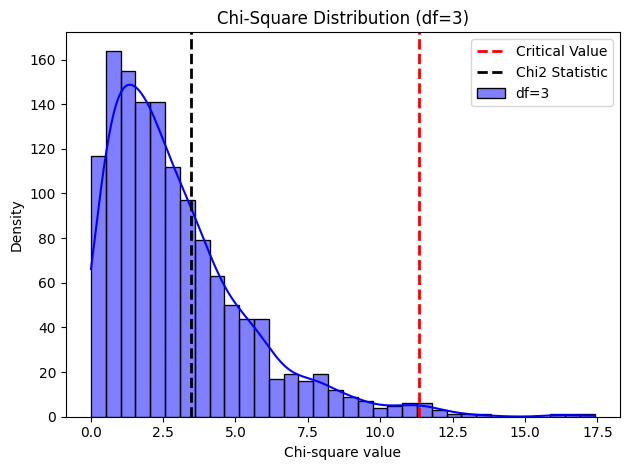

In [70]:
# let's have a look at the chi square test plot
generate_chi2_plot(critical_val=critical_val,
                   chi2_stats=chi2_stats,
                   _df=_df,cl='b',
                   size=equal_prop*4)

>**Based on the chi-square test results at both 95% and 99% confidence levels, there is no statistically significant difference in the proportion of patients seeking medical insurance across different regions. This suggests that patients from all regions are equally likely to seek medical insurance.**

>**Furthermore, from a practical perspective, it's reasonable to assume that individuals in all regions would require medical care at some point. This aligns with the statistical findings, reinforcing the conclusion that there is no significant regional variation in the need for medical insurance.**


# Test for Independence
---

#### Formulating Hypothesis : **Is there enough evidence to suggest that different BMI Category is independent of sex?**

**Null Hypothesis (H0)**: BMI Category is independent of sex.   


**Alternative Hypothesis (H1)**: BMI Category is not independent of sex.


In [83]:
# dropping the underweight from bmi category as it violates the assumption o chi2 test i.e. obs. frq. > 5
obs_crosstab = pd.crosstab(index=df.query('bmi_category != "underweight"')['bmi_category'],
                       columns=df['sex'])

obs_crosstab

sex,female,male
bmi_category,,
normal,119,108
obesity,342,374
overweight,189,186


In [84]:
row_total = obs_crosstab.sum(axis=1)
col_total = obs_crosstab.sum(axis=0)

expected_freq = pd.DataFrame(np.outer(row_total,col_total) / row_total.sum(),
             columns=obs_crosstab.columns,
             index=obs_crosstab.index)
expected_freq

sex,female,male
bmi_category,,
normal,111.949924,115.050076
obesity,353.110774,362.889226
overweight,184.939302,190.060698


In [91]:
chi2_stats,p_value,dof,expected = stats.chi2_contingency(observed=obs_crosstab)

print("Chi-square test statistic:", chi2_stats)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square test statistic: 1.7417050891629815
p-value: 0.4185945265849137
Degrees of freedom: 2


In [89]:
critical_val = stats.chi2.ppf(0.95, df=dof)
chi2_stats > critical_val

False

In [90]:
p_value < 0.05

False

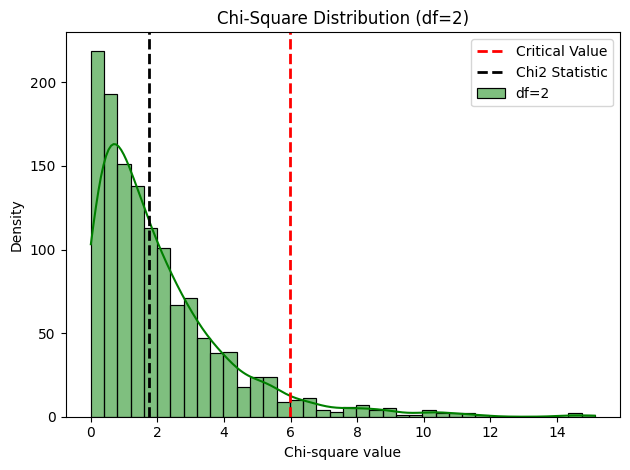

In [97]:
generate_chi2_plot(critical_val=critical_val,
                   chi2_stats=chi2_stats,
                   _df=dof,cl='g',
                   size=row_total.sum())

> **As the chi2_statistic falls under the non-rejection region, from the given data we can conclude that the BMI Category is independent of sex of patients.**